# CUNEF MUCD 2022/2023

# Machine Learning
# Análisis de Fraude¶

### Autores:
- Gozde Yazganoglu
- Irma Sanchez

# Importación de Librerías


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import pickle
import warnings
warnings.filterwarnings('ignore')

from aux_func import evaluate_model, cargar_modelo

# Cargo de los Datos y Processor

In [2]:
xtrain = pd.read_parquet("../data/processed/xtrain.parquet")
ytrain = pd.read_parquet("../data/processed/ytrain.parquet")
xtest = pd.read_parquet("../data/processed/xtest.parquet")
ytest = pd.read_parquet("../data/processed/ytest.parquet")

In [3]:
#Cargamos pipeline preprocesado
preprocessor = cargar_modelo('../models/preprocessor.pickle')

# SUPPORT VECTOR MACHINE

SVM  es un algoritmo de aprendizaje automático supervisado capaz de realizar clasificación, regresión e incluso detección de valores atípicos. Funciona dibujando una linea recta entre dos clases

In [4]:
clf_svm = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', SVC(kernel = 'sigmoid', probability= True, random_state=0))])

In [5]:
clf_svm.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'connection_time',
                                                   'oldbalanceOrg', 'age',
                                                   'newbalanceOrig',
                                                   'user_number',
                                                   'user_connections',
                                                   'security_alert',
                                                   'oldbalanceDest',
      

In [6]:
with open('../models/model_SVM.pickle', 'wb') as f:
    pickle.dump(clf_svm, f)

In [7]:
with open('../models/model_SVM.pickle', 'rb') as f:
    clf_svm = pickle.load(f)

In [8]:
ypred = clf_svm.predict(xtest)
ypred_proba = clf_svm.predict_proba(xtest)
evaluate_model(ytest,ypred)

Accuracy of the model: 0.9979877452733472

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.02      0.02      0.02       228

    accuracy                           1.00    209715
   macro avg       0.51      0.51      0.51    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209289    198]
 [   224      4]]



De todos los casos en los que hubo fraude, el modelo solo ha predicho el 0.02%. Sin embargo el accuracy es bueno debido a que tenemos muchos más casos de 'no fraude', por eso piensa que predice bien.

# Ajuste del umbral de predicción

In [36]:

# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.001548, G-Mean=0.598
ROC-AUC score of the model: 0.5882601139508804
Accuracy of the model: 0.7483680232696756

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86    209487
           1       0.00      0.47      0.00       228

    accuracy                           0.75    209715
   macro avg       0.50      0.61      0.43    209715
weighted avg       1.00      0.75      0.86    209715


Confusion matrix: 
[[156836  52651]
 [   120    108]]



# Graficos

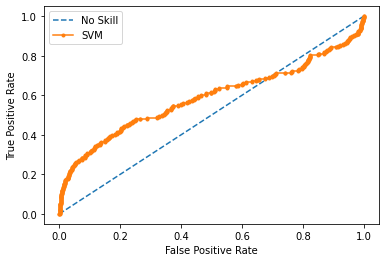

In [37]:
import matplotlib.pyplot as plt
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [14]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.001548, G-Mean=0.598


PR CURVE

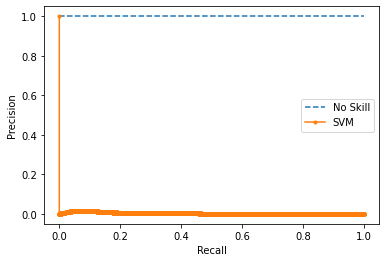

In [31]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(ytest, yhat)
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='SVM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.012233, F-Score=nan


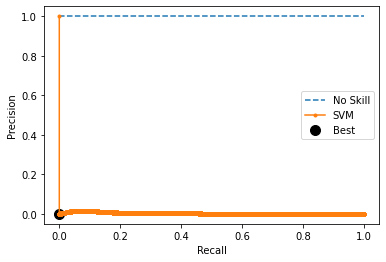

In [33]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='SVM')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [34]:
# evaluate the model
score = f1_score(ytest, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.01860


CUMULATIVE GAINS CURVE

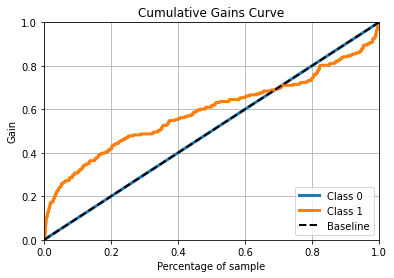

In [23]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(ytest, ypred_proba)
plt.show()

El 20 % de la muestra Class1, acumula el 40% de casos positivos

LIFT CURVE

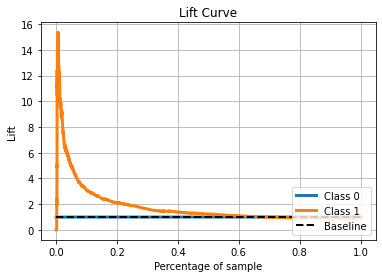

In [25]:
skplt.metrics.plot_lift_curve(ytest, ypred_proba)
plt.show()

Tomando el 20% de la muestra de Class1, el modelo es 2 veces mejor que la aleatoriedad